In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

# GBIF - The Global Biodiversity Information Facility

This notebook shows how to use the biological occurrence data from GBIF in the previous notebook to make biodiversity maps.

## Mapping Biodiversity

If you're interested in biodiversity, or the number of species in a given area, you might want to visualize the data with a map. Heatmaps are particularly good for this, with color varying by the number of species in an area. Right now, we could approach this in a couple different ways with our data.

1. We can map the number of species per country. Mapping by country is a good place to start, but it could be a little misleading since some countries are very large and they may encompass many different types of habitats. This is pretty simple, just calculate the number of species in each country, then use a choropleth style plotting package to map it. 

(Side note: GBIF actually has a mapping API as well. It doesn't quite do what I want for this little exercise, but if definitely check it out first because it's very easy to use!)

In [2]:
#Read back in csv file
df = pd.read_csv("../data/Ayenia_cleaned_dataframe.csv")

In [3]:
#Mapping by country is easiest when using the ISO three-letter codes for country
c_codes = {}
for each in list(df['country'].unique()):
    c_codes[each] = None

c_codes['Brazil'] = 'BRA'
c_codes['Nicaragua'] = 'NIC'
c_codes['United States of America'] = 'USA'
c_codes['El Salvador'] = 'SLV'
c_codes['Mexico'] = 'MEX'
c_codes['Dominican Republic'] = 'DOM'
c_codes['Costa Rica'] = 'CRI'
c_codes['Colombia'] = 'COL'
c_codes['Argentina'] = 'ARG'
c_codes['Bolivia, Plurinational State of'] = 'BOL'
c_codes['Cuba'] = 'CUB'
c_codes['Jamaica'] = 'JAM'
c_codes['Peru'] = 'PER'
c_codes['Paraguay'] = 'PRY'
c_codes['Guatemala'] = 'GTM'
c_codes['Puerto Rico'] = 'PRI'
c_codes['United States Minor Outlying Islands'] = 'UMI'
c_codes['Ecuador'] = 'ECU'
c_codes['Uruguay'] = 'URY'
c_codes['Guyana'] = 'GUY'
c_codes['Venezuela, Bolivarian Republic of'] = 'VEN'
c_codes['Honduras'] = 'HND'
c_codes['Haiti'] = 'HTI'
c_codes['Bahamas'] = 'BHS'
c_codes['Panama'] = 'PAN'
c_codes['Virgin Islands, U.S.'] = 'VIR'
c_codes['Montserrat'] = 'MSR'

In [4]:
#Create a new dataframe with just number of species per country and the country code
df_plot = pd.DataFrame(df.groupby('country')['species'].nunique().sort_values(ascending=False))
df_plot['code'] = df_plot.index.map(c_codes)

In [5]:
#Load a country map, restrict it to the New World, and join with the dataframe with species count
countries = gpd.read_file("../data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp", encoding = 'UTF-8')
countries = countries[['NAME', 'ISO_A3', 'CONTINENT', 'geometry']]
countries = countries[(countries['CONTINENT'] == 'North America') | (countries['CONTINENT'] == 'South America')]
countries = countries.merge(df_plot, how = 'outer', left_on = 'ISO_A3', right_on = 'code')
countries.drop('code', axis = 1, inplace = True)
countries['species'].fillna(value = 0, inplace = True)
countries.dropna(inplace = True)

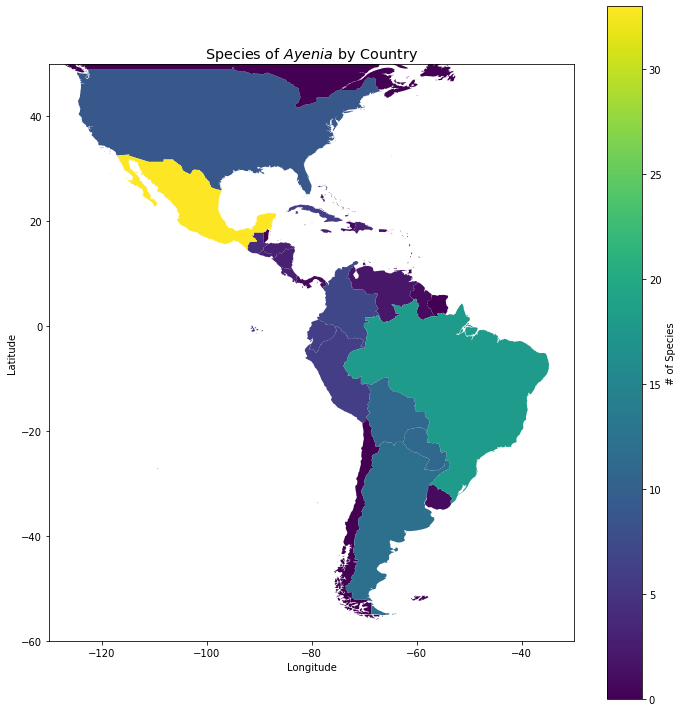

In [6]:
fig, ax = plt.subplots(1, 1, figsize= (10, 10))

countries.plot(column='species', 
               ax = ax, 
               legend = True,
               legend_kwds={'label': "# of Species"})
plt.xlim((-130, -30))
plt.ylim((-60, 50))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(r"Species of $Ayenia$ by Country", fontdict = {'fontsize': 'x-large'})
plt.tight_layout()
plt.savefig("Ayenia_choropleth.png", dpi = 300);

As you can tell, this map is a little misleading as to what parts of the New World these plants are found. In reality, _Ayenia_ is only found from the southernmost part of the US to the northernmost part of Argentina. By coloring an entire country, it makes it look like you could potentially find these countries way outside of their distribution range. I have some more issues with this choropleth that could probably fixed with tweaking a lot more parameters, but since this isn't really showing what I want anyway, I'm going to leave it as it is. 

Now to the second option for mapping:
2. Since we have the GPS points for each record, we can count how many different species are found in rasterized bins across the range. 

__Idea:__ Use rasterio to create a raster grid with the right projection/resolution from the min/max values in the gps coordinates

- change coordinates to geopandas df
- import grid
- calculate 'overlap'?
- for each grid cell, how many different species, save as new feature of grid cell
- save grid as raster, plot with world raster layer

In [13]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [14]:
df.columns

Index(['species', 'decimalLongitude', 'decimalLatitude', 'country'], dtype='object')

In [73]:
species_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['decimalLongitude'], df['decimalLatitude']), crs = "EPSG:4326")

In [16]:
species_gdf

,species,decimalLongitude,decimalLatitude,country,geometry
0,Ayenia tomentosa,-40.700556,-19.530000,Brazil,POINT (-40.70056 -19.53000)
1,Ayenia tomentosa,-40.700556,-19.530000,Brazil,POINT (-40.70056 -19.53000)
2,Ayenia tomentosa,-38.646389,-8.592222,Brazil,POINT (-38.64639 -8.59222)
3,Ayenia tomentosa,-38.023611,-8.105278,Brazil,POINT (-38.02361 -8.10528)
4,Ayenia tomentosa,-38.113056,-8.592222,Brazil,POINT (-38.11306 -8.59222)
...,...,...,...,...,...
3644,Ayenia odonellii,-64.170000,-31.140000,Argentina,POINT (-64.17000 -31.14000)
3645,Ayenia tomentosa,-56.440000,-24.090000,Paraguay,POINT (-56.44000 -24.09000)
3646,Ayenia tomentosa,-56.770000,-26.020000,Paraguay,POINT (-56.77000 -26.02000)
3647,Ayenia odonellii,-61.400000,-26.830000,Argentina,POINT (-61.40000 -26.83000)


In [30]:
long_range = list(range(-130, -29))
lat_range = list(range(-60, 51))

In [101]:
poly_list = []

for x in long_range:
    for y in lat_range:
        new_poly = Polygon([(x, y), (x + 0.99999, y), (x + 0.99999, y + 0.99999), (x, y + 0.99999)])
        poly_list.append(new_poly)

In [102]:
grid_df_1d = gpd.GeoDataFrame(geometry = poly_list, crs = species_gdf.crs)

In [103]:
grid_df_1d['cell_no'] = list(range(0, len(grid_df_1d)))

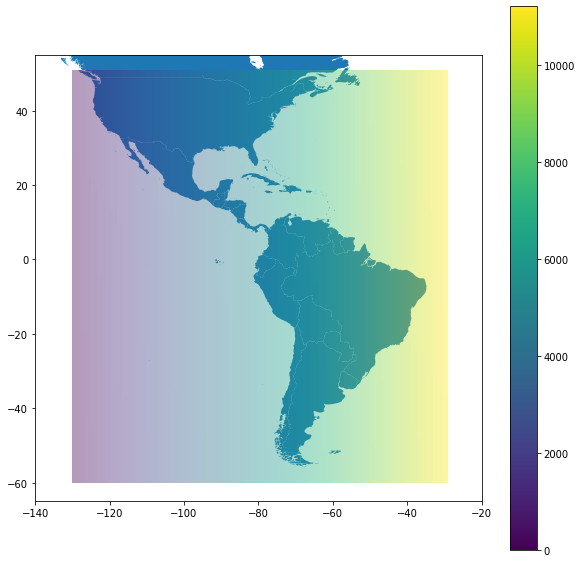

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
countries.plot(ax = ax)
grid_df_1d.plot(column = 'cell_no', ax = ax, legend = True, alpha = 0.4)
plt.xlim((-140, -20))
plt.ylim((-65, 55));


In [ ]:
for point in species_gdf['geometry']:
    if point.within(grid_df_1d)